# CLIMATE ANALYSIS

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
            
# Calculate the date 1 year ago from the last data point in the database
start_date = dt.datetime(2017, 8, 23)
year_ago = start_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.head()


,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [13]:
# Sort the dataframe by date
df = df.sort_values(by = 'date')
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


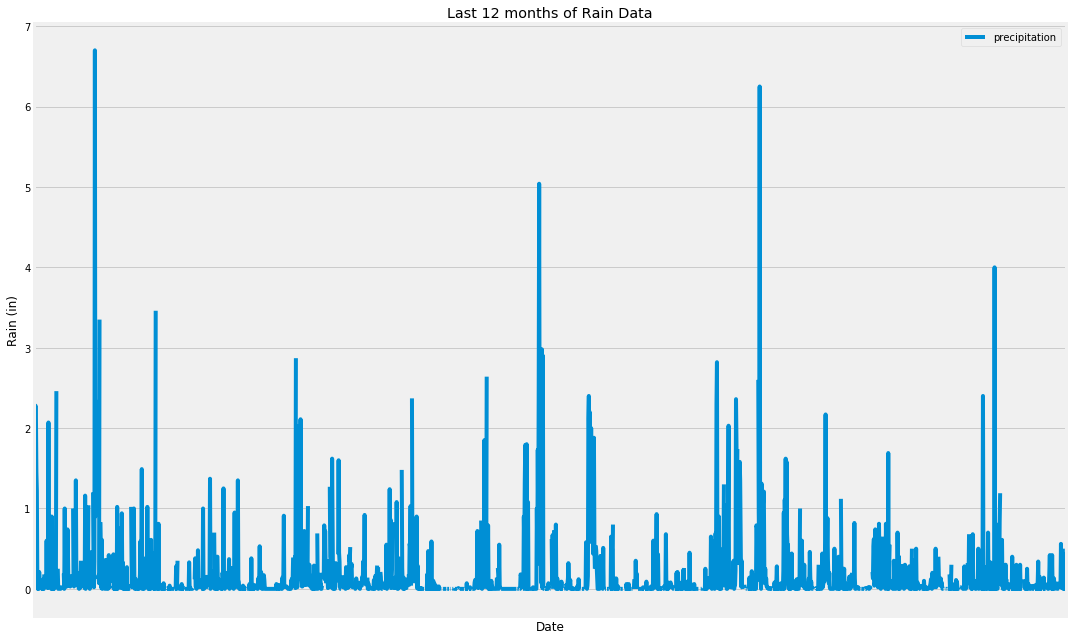

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
f, ax = plt.subplots(figsize = (15,9))
df.plot(ax = ax, x_compat=True)

ax.set_xlabel('Date')
ax.set_ylabel('Rain (in)')
ax.set_title('Last 12 months of Rain Data')

plt.xticks([])

plt.savefig("Images/rain.png")

plt.tight_layout()
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.id).distinct().count()
count_stations

9

In [17]:
# # What are the most active stations? (i.e. what stations have the most rows)?
# # # List the stations and the counts in descending order.
station_activity = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active = station_activity[0][0]

temps = session.query(func.min(Measurement.tobs),
                      func.max(Measurement.tobs),
                      func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

low_temp = round(temps[0][0], 1)
high_temp = round(temps[0][1], 1)
avg_temp = round(temps[0][2], 1)

print(f"The most active station is station number {most_active}.")
print(f"It's lowest recorded temp is {low_temp} degrees Fahrenheit")
print(f"It's highest recorded temp is {high_temp} degrees Fahrenheit")
print(f"It's average recorded temp is {avg_temp} degrees Fahrenheit")


The most active station is station number USC00519281.
It's lowest recorded temp is 54.0 degrees Fahrenheit
It's highest recorded temp is 85.0 degrees Fahrenheit
It's average recorded temp is 71.7 degrees Fahrenheit


In [19]:
# Choose the station with the highest number of temperature observations.
most_active

# Query the last 12 months of temperature observation data for this station
temp_raw = (session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date > year_ago).\
            filter(Measurement.station == most_active).\
            order_by(Measurement.date).all())
temp_df = pd.DataFrame(temp_raw)

temp_df.set_index('date', inplace=True)
temp_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


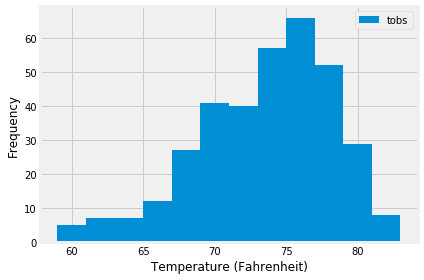

In [20]:
# plot the results as a histogram
#plot histogram
f, ax = plt.subplots()
temp_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')

#save figure
plt.savefig("Images/temp_histogram.png")

#plot
plt.tight_layout()
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-12-20'
trip_end = '2017-01-04'

trip_temps = calc_temps(trip_start, trip_end)
tmin = trip_temps[0][0]
tavg = trip_temps[0][1]
tmax = trip_temps[0][2]

print(f"My trip to Hawaii this winter is gonna be killer!")
print(f"The coldest day is only going to be {tmin},")
print(f"The average temp is going to be a perfect {tavg},")
print(f"The hottest day is going to be a gnarly {tmax} degrees!")

My trip to Hawaii this winter is gonna be killer!
The coldest day is only going to be 62.0,
The average temp is going to be a perfect 71.29,
The hottest day is going to be a gnarly 78.0 degrees!


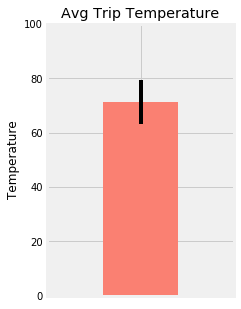

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak_delta = tmax - tmin

plt.figure(figsize=(3, 5))
plt.bar(1, tavg, yerr=(peak_delta/2), tick_label='', color='salmon')
plt.ylim(0, 100)
plt.xlim(0, 2)
plt.ylabel("Temperature")
plt.title("Avg Trip Temperature")
plt.show()

In [24]:
# # Calculate the total amount of rainfall per weather station
#     for your trip dates using the previous year's matching dates.
# # Sort this in descending order by precipitation amount and 
#     list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.total(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

rain_q = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start)
                   .filter(Measurement.date <= trip_end)
                   .group_by(Station.station)
                   .order_by(func.total(Measurement.prcp).desc())
                   .all())

rain_df = pd.DataFrame(np.array(rain_q))
rain_df = rain_df.rename(columns={0: "Station", 1: "Name", 2: "Total Rainfall", 3: "Latitude", 4: "Longitude", 5: "Elevation"})

rain_df

,Station,Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",10.17,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",2.8899999999999997,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.17,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.55,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.71,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.24000000000000002,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.06,21.3934,-157.9751,11.9


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
 
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2019-12-20'
end_date = '2020-01-04'

# Use the start and end date to create a range of dates
start_day = int(start_date[-2:])
end_day = int(end_date[-2:])
trip_days = start_day - end_day

# Stip off the year and save a list of %m-%d strings
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days), '%m-%d') 
            for days in range(0, trip_days)]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in date_list]

normals

[[(65.0, 72.91304347826087, 81.0)],
 [(67.0, 72.13953488372093, 78.0)],
 [(67.0, 71.1304347826087, 77.0)],
 [(61.0, 70.34693877551021, 78.0)],
 [(62.0, 70.0625, 78.0)],
 [(60.0, 71.75, 79.0)],
 [(63.0, 71.44680851063829, 77.0)],
 [(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)],
 [(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = [np.array(normal[0]) for normal in normals]

normals_df = pd.DataFrame(normals)

normals_df["Date"] = date_list

normals_df = normals_df.set_index("Date")
normals_df = normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
normals_df


,Low Temp,Avg Temp,High Temp
Date,,,
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0


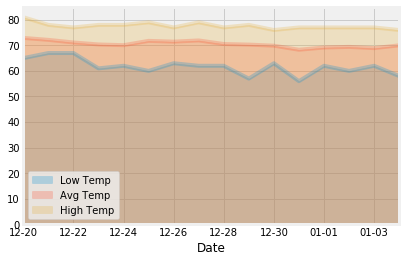

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=.250)